In [1]:
import pandas as pd
import numpy as np
import re
from dateutil import parser

# --------------------------------------------------
# 1. Extract the earliest date from Heard_Date
# --------------------------------------------------
def extract_first_heard_date(value):
    """
    Extract only the first date from a Heard_Date string.
    Returns NaT if extraction fails.
    """
    if pd.isna(value) or value == "Unknown":
        return pd.NaT

    try:
        # Search for first date pattern in various formats
        match = re.search(
            r'\b\d{1,2}-[A-Za-z]{3}-\d{2,4}|\b[A-Za-z]+ \d{1,2}, \d{4}',
            value
        )
        if match:
            return parser.parse(match.group(), fuzzy=True)
        return pd.NaT
    except Exception:
        return pd.NaT


# --------------------------------------------------
# 2. Filter valid judges
# --------------------------------------------------
def filter_valid_judges(df):
    """
    - Remove rows where Judge == 'Unknown'
    - Handle empty strings and NaN
    - Keep rows where Case_Duration_Days is valid
    """
    df = df.copy()

    df["Judge"] = df["Judge"].astype(str).str.strip()

    df = df[
        (df["Judge"].str.lower() != "unknown") &
        (df["Judge"] != "") &
        (df["Judge"].notna())
    ]

    df = df[
        df["Case_Duration_Days"].notna() &
        (df["Case_Duration_Days"] >= 0)
    ]

    return df


# --------------------------------------------------
# 3. Calculate judge statistics
# --------------------------------------------------
def calculate_judge_stats(df):
    """
    Compute statistics per judge:
    - Average case duration in days
    - Number of cases handled
    """
    return (
        df.groupby("Judge", as_index=False)
          .agg(
              avg_case_duration_days=("Case_Duration_Days", "mean"),
              case_count=("Case_Duration_Days", "count")
          )
          .sort_values("avg_case_duration_days", ascending=False)
    )


# --------------------------------------------------
# 4. Load dataset
# --------------------------------------------------
df = pd.read_csv("canlii_final_report_20.csv")


# --------------------------------------------------
# 5. Process date columns
# --------------------------------------------------
df["Released_Date"] = pd.to_datetime(df["Released_Date"], errors="coerce")
df["Heard_Date_Parsed"] = df["Heard_Date"].apply(extract_first_heard_date)


# --------------------------------------------------
# 6. Calculate case duration
# Definition: Released_Date - first Heard_Date
# --------------------------------------------------
df["Case_Duration_Days"] = (
    df["Released_Date"] - df["Heard_Date_Parsed"]
).dt.days


# --------------------------------------------------
# 7. Filter valid judges
# --------------------------------------------------
df_clean = filter_valid_judges(df)


# --------------------------------------------------
# 8. Calculate judge-level statistics
# --------------------------------------------------
judge_stats_df = calculate_judge_stats(df_clean)


# --------------------------------------------------
# 9. Save results
# --------------------------------------------------
judge_stats_df.to_csv(
    "judge_case_duration_and_count.csv",
    index=False
)

print("Completed: Calculated average case duration and number of cases per judge")


Completed: Calculated average case duration and number of cases per judge


/var/folders/tt/8t254_fd43l2np52syz3hzg00000gn/T/ipykernel_51709/738676434.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


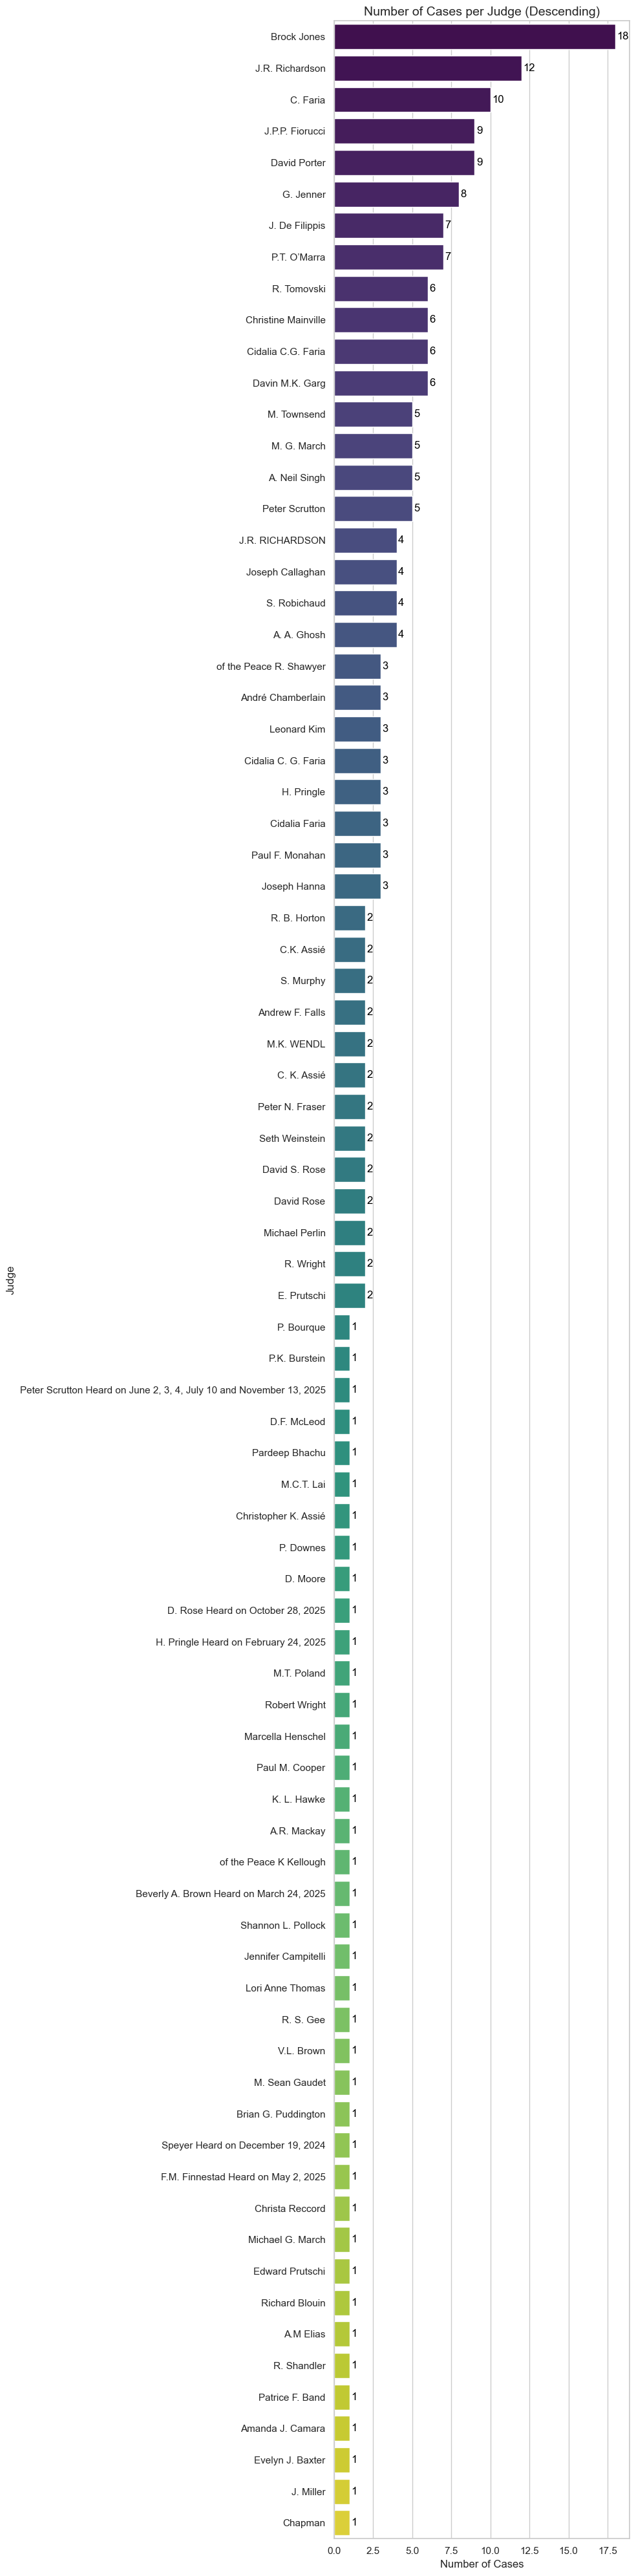

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# Dynamically adjust figure height based on number of judges
num_judges = len(judge_stats_df)
plt.figure(figsize=(10, max(6, num_judges * 0.5)))  # 0.5 inch per judge minimum

# Sort by case count descending
judge_stats_sorted = judge_stats_df.sort_values(by="case_count", ascending=False)

# Create bar plot
sns.barplot(
    x="case_count",
    y="Judge",
    data=judge_stats_sorted,
    palette="viridis"
)

plt.title("Number of Cases per Judge (Descending)", fontsize=14)
plt.xlabel("Number of Cases", fontsize=12)
plt.ylabel("Judge", fontsize=12)

# Display the count values on the bars
for index, row in enumerate(judge_stats_sorted.itertuples()):
    plt.text(
        row.case_count + 0.1,   # slightly offset to the right
        index,                  # y-position matches bar index
        int(row.case_count),
        color='black',
        va="center"
    )

plt.tight_layout()
plt.show()


/var/folders/tt/8t254_fd43l2np52syz3hzg00000gn/T/ipykernel_51709/2616771346.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


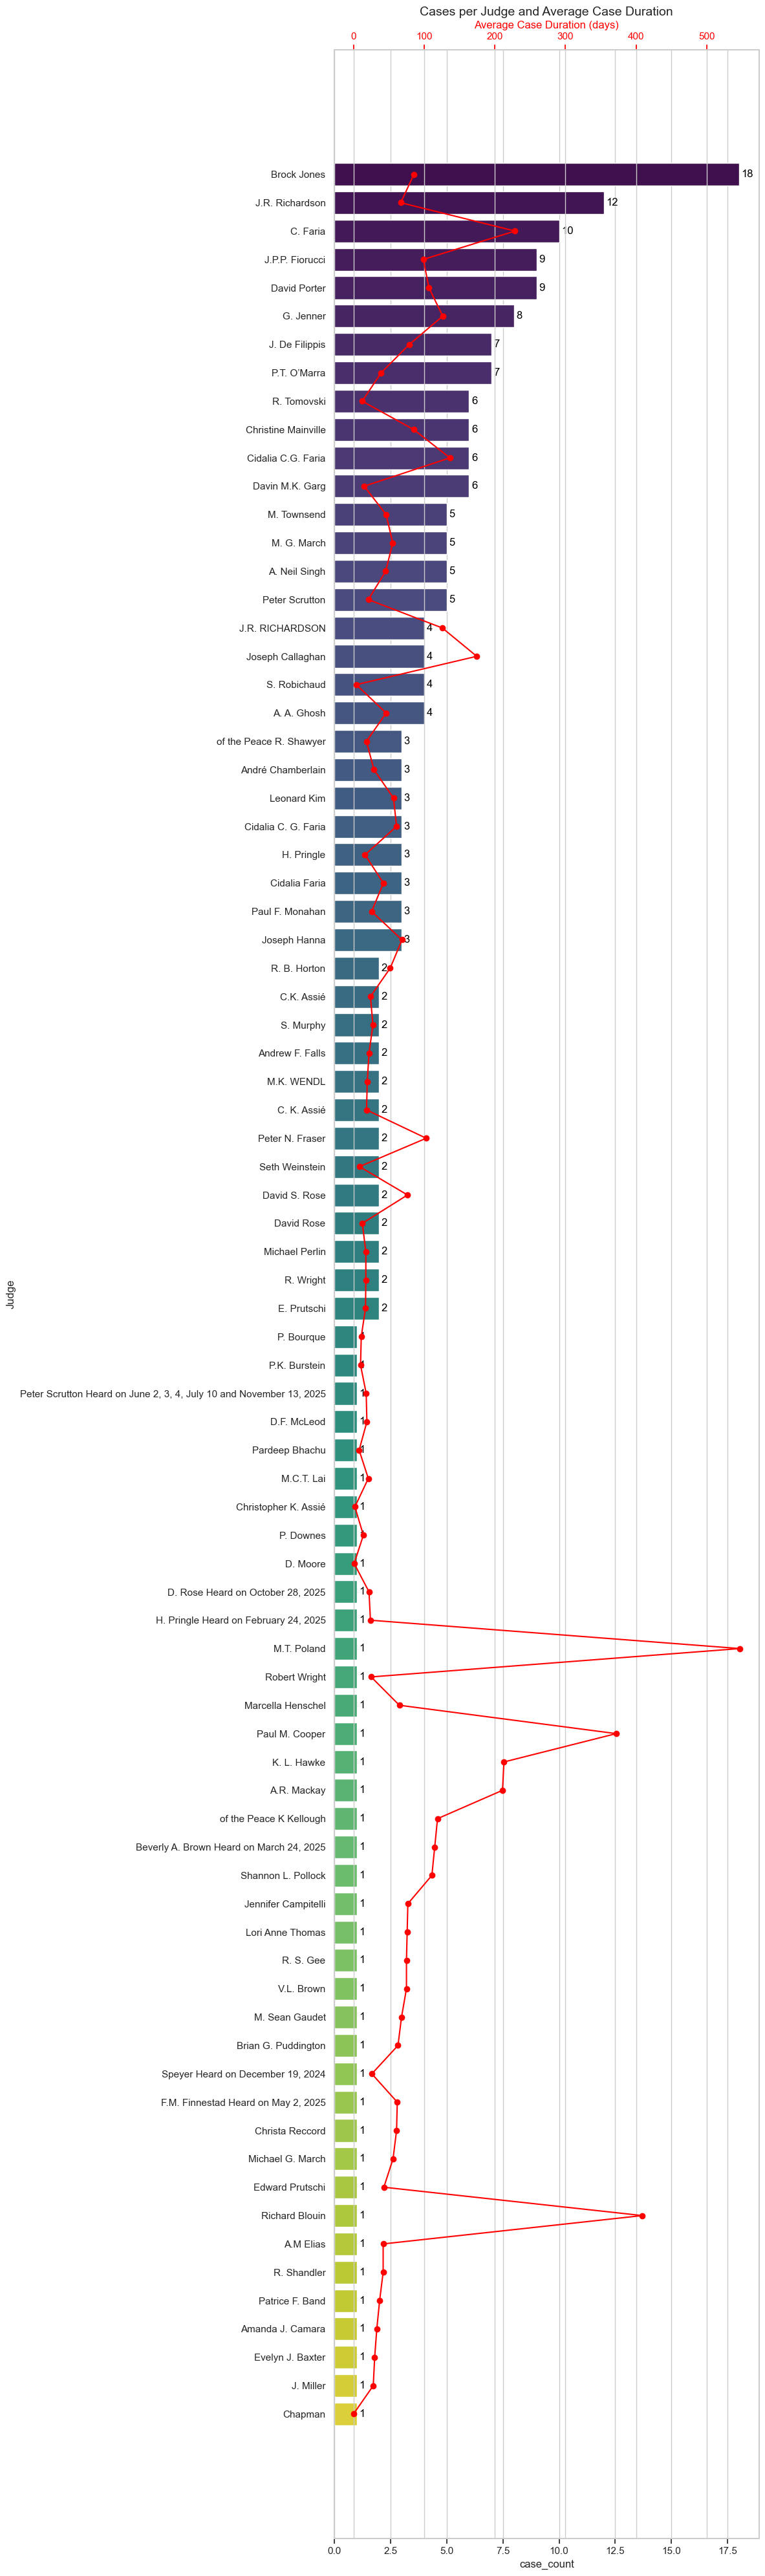

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by case count descending
judge_stats_sorted = judge_stats_df.sort_values(by="case_count", ascending=False)

# Set figure size dynamically
num_judges = len(judge_stats_sorted)
plt.figure(figsize=(12, max(6, num_judges * 0.5)))
sns.set(style="whitegrid")

# Primary axis: case count
ax = sns.barplot(
    x="case_count",
    y="Judge",
    data=judge_stats_sorted,
    palette="viridis"
)

# Add counts on the bars
for index, row in enumerate(judge_stats_sorted.itertuples()):
    ax.text(
        row.case_count + 0.1,
        index,
        int(row.case_count),
        color='black',
        va="center"
    )

# Secondary axis: average duration
ax2 = ax.twiny()  # share y-axis
ax2.plot(
    judge_stats_sorted["avg_case_duration_days"],
    range(len(judge_stats_sorted)),
    color="red",
    marker="o",
    linestyle="-",
    label="Avg Case Duration (days)"
)

ax2.set_xlabel("Average Case Duration (days)", color="red")
ax2.tick_params(axis='x', colors='red')

plt.title("Cases per Judge and Average Case Duration", fontsize=14)
plt.tight_layout()
plt.show()
